In [1]:
from Model.ReplayBuffer import ReplayBuffer
from Model.policy_net import ConvSACPolicy
from Model.q_net import ConvSACQNet
from Model.v_net import ConvSACValue
from Model.SAC_base import target_initialize
import lib_duju.utils as duju_utils
from Model.ImageBuffer import ImageBuffer

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2

from dm_control import suite
import numpy as np

In [2]:
def soft_target_update(main, target, tau):
    params_main = list(main.parameters())
    params_target = list(target.parameters())

    assert len(params_main) == len(params_target)

    for pi in range(len(params_main)):
        params_target[pi].data.copy_((1 - tau) * params_target[pi].data + tau * params_main[pi].data)

def target_initialize(main, target):
    params_main = list(main.parameters())
    params_target = list(target.parameters())

    assert len(params_main) == len(params_target)

    for pi in range(len(params_main)):
        params_target[pi].data.copy_(params_main[pi].data)

def conv_train(policy, Qnet, Value_main, Value_target, replay_buffer, image_buffer,batch_size, alpha, gamma):

    device = policy.device

    s_batch, a_batch, r_batch, t_batch, _ = replay_buffer.sample_batch(batch_size)


    a_batch = torch.FloatTensor(a_batch).to(device)
    r_batch = torch.FloatTensor(r_batch).to(device)

    s1_batch = []
    s2_batch = []

    for i in s_batch:
        s, s2 = image_buffer.get_state_and_next(i)
        s1_batch.append(s)
        s2_batch.append(s2)

    s_batch = torch.FloatTensor(np.array(s1_batch)).to(device)
    s2_batch = torch.FloatTensor(np.array(s2_batch)).to(device)

    MSE = nn.MSELoss()


    q1, q2 = Qnet.forward(s_batch, a_batch)
    v_main = Value_main.forward(s_batch)

    pi, logp_pi = policy.sample_with_logp(s_batch)
    pi_no_grad = pi.detach()
    
    print(logp_pi[0])

    with torch.no_grad():
        y_q = r_batch + gamma * Value_target.forward(s2_batch)
        y_v = torch.min(torch.cat(list(Qnet.forward(s_batch, pi_no_grad)),dim=1),dim=1,keepdim=True)[0] - alpha * logp_pi  # The shape must be [Batch, 1]

    V_loss = MSE(v_main, y_v)
    Q1_loss = MSE(q1, y_q)
    Q2_loss = MSE(q2, y_q)

    PI_loss = torch.mean((-1.0) * torch.mean(torch.cat(list(Qnet.forward(s_batch, pi)),dim=1), dim=1, keepdim=True) + alpha * logp_pi)


    Value_main.optimizer.zero_grad()
    V_loss.backward()
    torch.nn.utils.clip_grad_value_(Value_main.parameters(), 1.0)
    Value_main.optimizer.step()

    Qnet.optimizer.zero_grad()
    Q1_loss.backward()
    Q2_loss.backward()
    torch.nn.utils.clip_grad_value_(Qnet.parameters(), 1.0)
    Qnet.optimizer.step()

    policy.optimizer.zero_grad()
    PI_loss.backward()
    torch.nn.utils.clip_grad_value_(policy.parameters(), 1.0)
    policy.optimizer.step()

    soft_target_update(Value_main, Value_target, 0.001)

    return np.max(v_main.detach().cpu().numpy())

In [3]:
exp_title = "CONV_CELU"

env = suite.load(domain_name="cartpole",task_name="swingup")

state_dim = duju_utils.state_1d_dim_calc(env)[-1]

stepsize = 10
channelsize = 3

step_channelsize = stepsize * channelsize

height = 48
width = 64

action_dim = env.action_spec().shape[-1]

buffer_size = 2e5
batch_size = 64

lr = 1e-3
device = torch.device("cuda")

replay_buffer = ReplayBuffer(buffer_size)
image_buffer = ImageBuffer(height,width, stepsize, channelsize, int(buffer_size*1.01))
eval_image_buffer = ImageBuffer(height, width, stepsize, channelsize, 1001)

policy = ConvSACPolicy(step_channelsize, height, width, action_dim, lr, device)
QNet = ConvSACQNet(step_channelsize, height, width, action_dim, lr, device)
VNet_main = ConvSACValue(step_channelsize, height, width, lr, device)
VNet_target = ConvSACValue(step_channelsize, height, width, lr, device)

target_initialize(VNet_main, VNet_target)

max_episode = 10000
image_idx = 0
eval_image_idx = 0

### Image Idx starts from 1

for epi_i in range(1, max_episode + 1):

    timestep = env.reset()
    ep_reward = 0.0

    # timestep, reward, discount, observation
    end, _, _, _ = timestep
    image_buffer.dm_add(env.physics.render(camera_id=0, width=64, height=48))
    image_idx += 1
    end = end.last()

    s = image_buffer.get_state(image_idx)

    while not end:
        a = policy.sample(torch.FloatTensor(s).to(device).view(1,step_channelsize,height,width)).cpu().numpy()[0]
        timestep = env.step(a)

        end, r, _, _ = timestep
        image_buffer.dm_add(env.physics.render(camera_id=0, width=64, height=48))
        image_idx += 1
        end = end.last()
        s2 = image_buffer.get_state(image_idx)

        replay_buffer.add(image_idx - 1, a, np.array([r]),np.array([end]), image_idx)

        s = s2
        ep_reward += r

    for _idx in range(500):
        max_v = conv_train(policy, QNet, VNet_main, VNet_target, replay_buffer, image_buffer, batch_size, alpha=0.2, gamma=0.99)

    print(epi_i, "***", ep_reward, "***", max_v)

    if (epi_i % 1) == 0 :

        timestep = env.reset()
        end, _, _, _ = timestep
        eval_image_buffer.dm_add(env.physics.render(camera_id=0, width=64, height=48))
        eval_image_idx += 1
        end = end.last()
        s = eval_image_buffer.get_state(eval_image_idx)

        eval_ep_reward = 0.0

        while not end:
            a = policy.mean_action(torch.FloatTensor(s).to(device).view(1,step_channelsize,height,width)).cpu().numpy()[0]
            timestep = env.step(a)

            end, r, _, s2 = timestep
            eval_image_buffer.dm_add(env.physics.render(camera_id=0, width=64, height=48))
            eval_image_idx += 1
            end = end.last()

            s2 = eval_image_buffer.get_state(eval_image_idx)

            s = s2
            eval_ep_reward += r

            frame = env.physics.render(camera_id=0, width=640, height=480) #[height, width, channel]
            #cv2.imshow("test", frame)
            #cv2.waitKey(1)


        print("Eval! *** ", eval_ep_reward)
        duju_utils.torch_network_save(policy,"trained/"+exp_title+"_"+str(epi_i)+".torch")
        duju_utils.torch_network_save(QNet, "trained/"+exp_title+"_"+str(epi_i)+".torch")
        duju_utils.torch_network_save(VNet_main, "trained/"+exp_title+"_"+str(epi_i)+".torch")
        duju_utils.torch_network_save(VNet_target, "trained/"+exp_title+"_"+str(epi_i)+".torch")

#cv2.destroyAllWindows()

tensor([-0.4974], device='cuda:0', grad_fn=<SelectBackward>)
tensor([2.2407], device='cuda:0', grad_fn=<SelectBackward>)
tensor([9.2878], device='cuda:0', grad_fn=<SelectBackward>)
tensor([9.7805], device='cuda:0', grad_fn=<SelectBackward>)
tensor([9.7601], device='cuda:0', grad_fn=<SelectBackward>)
tensor([-1.4649], device='cuda:0', grad_fn=<SelectBackward>)
tensor([-0.6817], device='cuda:0', grad_fn=<SelectBackward>)
tensor([9.5166], device='cuda:0', grad_fn=<SelectBackward>)
tensor([4.7144], device='cuda:0', grad_fn=<SelectBackward>)
tensor([0.6065], device='cuda:0', grad_fn=<SelectBackward>)
tensor([5.7705], device='cuda:0', grad_fn=<SelectBackward>)
tensor([8.7491], device='cuda:0', grad_fn=<SelectBackward>)
tensor([-1.4964], device='cuda:0', grad_fn=<SelectBackward>)
tensor([-0.5030], device='cuda:0', grad_fn=<SelectBackward>)
tensor([-0.4822], device='cuda:0', grad_fn=<SelectBackward>)
tensor([-0.5853], device='cuda:0', grad_fn=<SelectBackward>)


KeyboardInterrupt: 

In [283]:

class ConvSACPolicy(nn.Module):
    def __init__(self, step_channelsize, height, width, action_dim, lr, device):
        super(ConvSACPolicy, self).__init__()

        self.step_channelsize = step_channelsize
        self.height = height
        self.width = width
        self.out_channels = 16

        self.conv_flatten_size = int(height * width * self.out_channels / (8 ** 2))

        print("Policy Net conv flatten size : ", self.conv_flatten_size)

        self.action_dim = action_dim
        self.actor_lr = lr
        self.device = device

        self.conv1 = torch.nn.Conv2d(in_channels=self.step_channelsize, out_channels=64,
                                kernel_size=3, stride=2, padding=1).to(device)
        self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=self.out_channels,
                                kernel_size=7, stride=4, padding=3).to(device)

        self.fc1 = nn.Linear(self.conv_flatten_size, 128).to(device)
        self.fc2 = nn.Linear(128, 128).to(device)

        self.mu = nn.Linear(128, action_dim).to(device)
        self.log_std = nn.Linear(128, action_dim).to(device)

        nn.init.uniform_(tensor=self.mu.weight, a = -3e-3, b=3e-3)
        nn.init.uniform_(tensor=self.mu.bias, a=-3e-3, b=3e-3)

        nn.init.uniform_(tensor=self.log_std.weight, a=-3e-3, b=3e-3)
        nn.init.uniform_(tensor=self.log_std.bias, a=-3e-3, b=3e-3)

        self.optimizer = optim.Adam(self.parameters(),lr)


    def forward(self, x):
        x = F.celu(self.conv1(x))
        print(1,x)
        x = F.celu(self.conv2(x))
        print(2,x)

        assert x.shape[-1] * x.shape[-2] * x.shape[-3] == self.conv_flatten_size

        x = x.view(-1,self.conv_flatten_size)
        print(3,x)
        x = F.celu(self.fc1(x))
        print(4,x)
        x = F.celu(self.fc2(x))
        print(5,x)

        mu = self.mu(x)
        log_std = self.log_std(x)
        log_std = torch.clamp(log_std, -20, 2)

        # It should return mu, log_std
        return mu, log_std

    def sample_with_logp(self, x):
        mu, log_std = self.forward(x)
        std = torch.exp(log_std)

        # print("mu",mu)
        # print("log_std", log_std)
        # print("std",std)

        normal = Normal(mu, std)
        x_t = normal.rsample()
        # print("x_t", x_t)
        logp = normal.log_prob(x_t)
        # print("logp 1",logp)

        y_t = torch.tanh(x_t)
        logp -= torch.log(1 - torch.pow(y_t, 2) + 1e-6)
        # print("y_t", y_t)
        # print("logp 2",logp)

        return y_t, logp

    def sample(self, x):

        with torch.no_grad():
            mu, log_std = self.forward(x)
            std = torch.exp(log_std)

            normal = Normal(mu, std)

            return torch.tanh(normal.sample())

    def mean_action(self, x):
        with torch.no_grad():
            mu, _log_std = self.forward(x)
            return torch.tanh(mu)




In [284]:
policy_print = ConvSACPolicy(step_channelsize, height, width, action_dim, lr, device)

Policy Net conv flatten size :  768


In [285]:
duju_utils.torch_network_load(policy_print,"trained/CONV_CELU_pi_20.torch")

In [286]:
env.reset()

TimeStep(step_type=<StepType.FIRST: 0>, reward=None, discount=None, observation=OrderedDict([('position', array([-0.01517324, -0.99999406,  0.00344663])), ('velocity', array([ 0.01130112, -0.01437519]))]))

In [300]:
tt = []

In [308]:
for _ in range(10):
    env.step(1.0)
    tt.append(env.physics.render(camera_id=0, width=64, height=48))


In [309]:
import matplotlib.pyplot as plt

In [317]:
import pandas as pd

In [320]:
pd.DataFrame(tt2[0][0]).iloc[20:28,28:36]

,28,29,30,31,32,33,34,35
20,-0.554688,-0.546875,-0.570312,-0.585938,-0.546875,-0.585938,-0.585938,-0.578125
21,-0.578125,-0.585938,-0.562500,-0.578125,-0.562500,-0.585938,-0.585938,-0.578125
22,-0.593750,-0.601562,-0.593750,-0.554688,-0.226562,0.093750,0.093750,0.101562
23,-0.453125,-0.476562,-0.476562,-0.492188,-0.148438,0.773438,0.773438,0.765625
24,-0.531250,-0.539062,-0.539062,-0.539062,-0.195312,0.773438,0.773438,0.773438
25,-0.609375,-0.609375,-0.601562,-0.617188,-0.617188,0.078125,0.531250,0.375000
26,-0.617188,-0.609375,-0.609375,-0.625000,-0.625000,-0.625000,0.445312,-0.304688
27,-0.617188,-0.617188,-0.601562,-0.617188,-0.625000,-0.390625,0.570312,-0.492188


In [323]:
pd.DataFrame(tt1[0][0]).iloc[20:28,28:36]

,28,29,30,31,32,33,34,35
20,-0.554688,-0.546875,-0.570312,-0.585938,-0.546875,-0.585938,-0.585938,-0.578125
21,-0.578125,-0.585938,-0.562500,-0.578125,-0.562500,-0.585938,-0.585938,-0.578125
22,-0.593750,-0.601562,-0.593750,-0.554688,-0.562500,0.093750,0.093750,0.101562
23,-0.453125,-0.476562,-0.476562,-0.492188,-0.492188,0.468750,0.773438,0.773438
24,-0.531250,-0.539062,-0.539062,-0.539062,-0.539062,0.468750,0.773438,0.773438
25,-0.609375,-0.609375,-0.601562,-0.617188,-0.617188,-0.226562,0.320312,0.640625
26,-0.617188,-0.609375,-0.609375,-0.625000,-0.625000,-0.625000,0.171875,0.218750
27,-0.617188,-0.617188,-0.601562,-0.617188,-0.625000,-0.507812,0.554688,-0.351562


In [322]:
pd.DataFrame(tt1[0][0]).iloc[20:28,28:36] - pd.DataFrame(tt2[0][0]).iloc[20:28,28:36]

,28,29,30,31,32,33,34,35
20,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
21,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
22,0.0,0.0,0.0,0.0,-0.335938,0.000000,0.000000,0.000000
23,0.0,0.0,0.0,0.0,-0.343750,-0.304688,0.000000,0.007812
24,0.0,0.0,0.0,0.0,-0.343750,-0.304688,0.000000,0.000000
25,0.0,0.0,0.0,0.0,0.000000,-0.304688,-0.210938,0.265625
26,0.0,0.0,0.0,0.0,0.000000,0.000000,-0.273438,0.523438
27,0.0,0.0,0.0,0.0,0.000000,-0.117188,-0.015625,0.140625


In [333]:
policy_print.conv2.weight

Parameter containing:
tensor([[[[-1.3107e-02, -1.7111e-02, -1.0026e-02,  ..., -1.7101e-04,
           -2.8048e-02, -1.7049e-02],
          [-8.9614e-04, -3.0800e-02, -2.0214e-02,  ..., -2.3366e-02,
           -2.3283e-02, -1.2665e-02],
          [-1.6529e-02, -7.1615e-03,  2.7464e-03,  ..., -1.1764e-02,
           -2.2131e-03, -2.0288e-02],
          ...,
          [-1.1869e-02,  1.4403e-02, -1.6661e-03,  ...,  4.2887e-03,
            4.3304e-03, -1.3484e-02],
          [ 1.6997e-02,  1.4051e-02,  2.0679e-03,  ..., -3.0694e-04,
            2.1737e-02,  8.2954e-03],
          [-1.1183e-03, -1.7130e-03,  1.4190e-02,  ..., -2.8317e-03,
           -2.2423e-03,  1.1600e-02]],

         [[ 3.9690e-02,  2.9143e-02,  1.9603e-02,  ...,  4.0232e-02,
            2.0215e-02,  2.1917e-02],
          [ 2.9454e-02,  3.4737e-02,  3.0421e-02,  ...,  2.8749e-02,
            4.0845e-02,  4.1093e-02],
          [ 8.1679e-03,  1.5809e-02,  1.7795e-02,  ...,  3.8631e-02,
            3.0107e-02,  3.9954e-02]

In [355]:
test = policy_print.conv2.weight[0].detach().cpu().numpy()
test

array([[[-1.31072663e-02, -1.71109177e-02, -1.00263031e-02, ...,
         -1.71014501e-04, -2.80484278e-02, -1.70494616e-02],
        [-8.96136800e-04, -3.07999663e-02, -2.02144813e-02, ...,
         -2.33656447e-02, -2.32825447e-02, -1.26652131e-02],
        [-1.65285431e-02, -7.16146920e-03,  2.74638413e-03, ...,
         -1.17636006e-02, -2.21313746e-03, -2.02875901e-02],
        ...,
        [-1.18688941e-02,  1.44031690e-02, -1.66607066e-03, ...,
          4.28865058e-03,  4.33037337e-03, -1.34843234e-02],
        [ 1.69970039e-02,  1.40509298e-02,  2.06794194e-03, ...,
         -3.06941511e-04,  2.17370372e-02,  8.29544477e-03],
        [-1.11826032e-03, -1.71296159e-03,  1.41901253e-02, ...,
         -2.83170189e-03, -2.24230788e-03,  1.15999030e-02]],

       [[ 3.96898091e-02,  2.91428603e-02,  1.96027402e-02, ...,
          4.02315818e-02,  2.02151705e-02,  2.19174568e-02],
        [ 2.94544417e-02,  3.47368084e-02,  3.04205269e-02, ...,
          2.87493523e-02,  4.08449546e

In [371]:
F.celu(torch.FloatTensor(np.array([-0.1])))

tensor([-0.0952])

1 tensor([[[[-0.3986, -0.5840, -0.5860,  ..., -0.5884, -0.5852, -0.5861],
          [-0.4966, -0.7010, -0.7009,  ..., -0.6995, -0.7011, -0.6927],
          [-0.4848, -0.6991, -0.6980,  ..., -0.6949, -0.6928, -0.6854],
          ...,
          [-0.2398, -0.6755, -0.6824,  ..., -0.6495, -0.6421, -0.6357],
          [-0.2269, -0.6419, -0.6438,  ..., -0.6877, -0.6844, -0.6811],
          [-0.2785, -0.6476, -0.6477,  ..., -0.6765, -0.6755, -0.6718]],

         [[-0.7104, -0.8228, -0.8086,  ..., -0.8230, -0.8204, -0.8152],
          [-0.8465, -0.9288, -0.9237,  ..., -0.9240, -0.9219, -0.9191],
          [-0.8551, -0.9354, -0.9334,  ..., -0.9343, -0.9276, -0.9228],
          ...,
          [-0.9918, -0.9992, -0.9991,  ..., -0.9945, -0.9952, -0.9961],
          [-0.9849, -0.9978, -0.9976,  ..., -0.9982, -0.9983, -0.9985],
          [-0.9774, -0.9959, -0.9955,  ..., -0.9992, -0.9992, -0.9993]],

         [[-0.4527, -0.6679, -0.6509,  ..., -0.6690, -0.6674, -0.6622],
          [-0.6312, -0.7990,

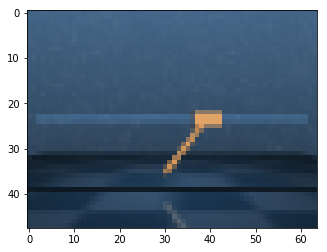

In [311]:
    frame = np.moveaxis(np.array(tt[-10:]), [0, 1, 2, 3], [0, 2, 3, 1])
    frame = frame / 128.0 - 1.0
    
    tt1 = frame
    
    mu, log_std = policy_print.forward(torch.FloatTensor(frame).reshape(1,30,48,64).to(device))
    print(mu, log_std)
    a = torch.tanh(mu).detach().cpu().numpy()
    print (a)
    print ("")
    env.step(a)
    tt.append(env.physics.render(camera_id=0, width=64, height=48))
    plt.imshow(tt[-1])

In [55]:
env.reset()
for _ in range(10):
    env.step(1.0)
    tt.append(env.physics.render(camera_id=0, width=64, height=48))

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='

[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='

[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='

[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='cuda:0', grad_fn=<AddmmBackward>) tensor([[-0.0728]], device='cuda:0', grad_fn=<ClampBackward>)
[[0.03344946]]

tensor([[0.0335]], device='

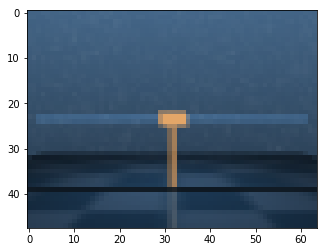

In [54]:
for _ in range(1000):
    mu, log_std = policy_print.forward(torch.FloatTensor(np.moveaxis(np.array(tt[-10:]), [0, 1, 2], [1, 2, 0]).reshape(1,30,48,64)).to(device))
    print(mu, log_std)
    a = torch.tanh(mu).detach().cpu().numpy()
    print (a)
    print ("")
    env.step(a)
    tt.append(env.physics.render(camera_id=0, width=64, height=48))
    plt.imshow(tt[-1])

In [ ]:
np.exp(2)